## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
data_path = "../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat"
out_dir = "./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


In [4]:
# load phi-psi data
time, phi, psi = np.loadtxt(data_path+colvar_file, usecols=(0,1,2), unpack=True)
print(phi.shape)

(100001,)


### run cluster scan on this data using uniform weights -->

In [5]:
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


In [6]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 50000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 50000
Number of frames to predict each model: 50001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              26.648          16.205
              1               2               1              27.004          28.610
              1               2               2              27.720          28.442
              1               2               3              27.629          27.692
              1               2               4              27.028          26.369
              1               2               5              26.091          28.713
              1               2               6              27.158          27.460
              1               2               7              25.9

              2               6               2              52.047          45.676
              2               6               3              51.659          44.547
              2               6               4              51.831          51.669
              2               6               5              50.825          31.173
              2               6               6              35.024          57.220
              2               6               7              53.290          40.369
              2               6               8                 nan          11.416
              2               6               9                 nan           9.505
              2               6              10              51.576          68.332
              3               1               1              27.155          15.097
              3               2               1              26.940          28.279
              3               2               2              33.461         

              4               5               5              51.280          38.912
              4               5               6              52.060          31.202
              4               5               7              52.020          54.650
              4               5               8              50.409          40.104
              4               5               9              49.050          34.961
              4               5              10              52.049          47.937
              4               6               1              33.395          57.924
              4               6               2              52.105          38.529
              4               6               3              53.161          43.331
              4               6               4              52.380          41.352
              4               6               5              30.405          66.568
              4               6               6              53.149         

In [8]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

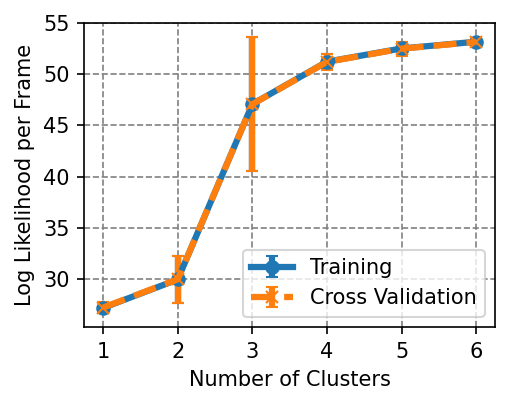

In [9]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 150, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Training")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cross Validation")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(loc="lower right")
plt.tight_layout()

## n_clusters = 2 

In [5]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              26.654          57.656
       2              28.043          56.933
       3              27.037          54.706
       4              51.716          30.483
       5              27.806          49.586
       6              26.528          55.497
       7              27.343          42.782
       8              27.177          52.945
       9              28.582          47.867
      10              38.601          42.927
      11              27.428          56.548
      12              27.037          52.575
      13              32.603          44.653
      14              27.310          55.000
      15              32.296          46.795
      16              26.772          54.349
      17              26.092          53.310
      18              31.241          46.291
      19       

In [6]:
with open("wsgmm_2state_wout_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [7]:
with open("wsgmm_2state_wout_weights.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

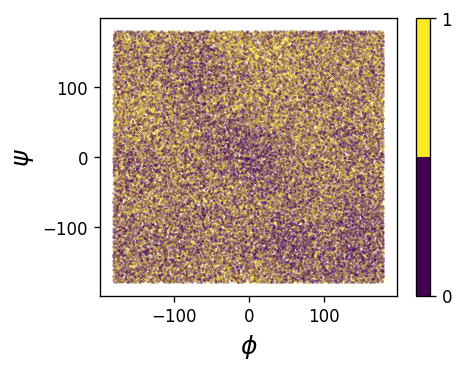

In [8]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3

In [9]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              32.630          66.477
       2              27.022          79.925
       3              26.168          74.396
       4              26.981          75.005
       5              50.207          50.750
       6              50.391          49.538
       7              29.718          73.220
       8              30.657          72.824
       9              26.744          76.846
      10              27.214          75.567
      11              30.223          69.674
      12              33.571          61.343
      13              32.657          69.888
      14              50.423          61.421
      15              26.966          68.036
      16              51.149          27.147
      17              27.106          80.994
      18              27.344          70.572
      19       

In [10]:
with open("wsgmm_3state_wout_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [11]:
with open("wsgmm_3state_wout_weights.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

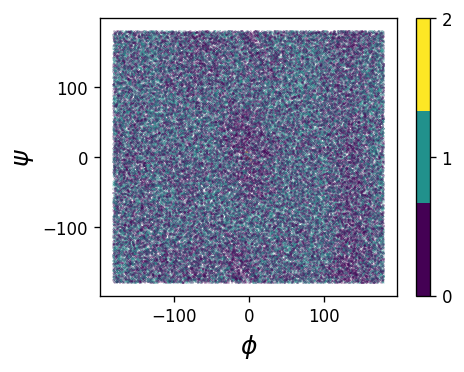

In [12]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4

In [13]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              31.249          89.344
       2              30.562          83.543
       3              27.904          94.795
       4              29.464          92.148
       5              50.953          55.639
       6              31.735          88.110
       7              49.688          82.987
       8              28.854          97.671
       9              49.718          76.632
      10              32.833          79.358
      11              28.388          98.657
      12              33.828          84.268
      13              44.222          81.796
      14              27.219         104.457
      15              27.997          92.674
      16              28.320          97.981
      17              50.887          77.026
      18              52.026          51.164
      19       

In [14]:
with open("wsgmm_4state_wout_weights.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [15]:
with open("wsgmm_4state_wout_weights.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

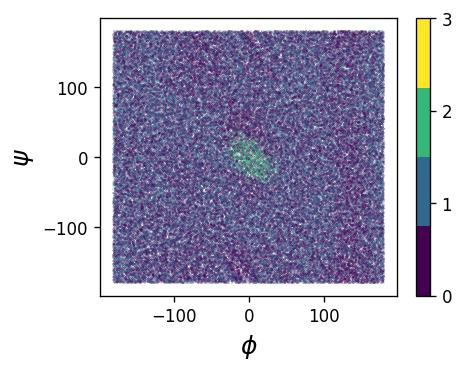

In [16]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)